In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
import tqdm
import seaborn as sns
import bisect

In [13]:

def perturb_normal_mixture(orig_means, orig_variances, orig_weights, 
                           comp_out=10000, alpha=500):
    """
    Returns a perturbation of a mixture:
    
    Given a mixture
            f(y) = \sum_j w_j N(y | \mu_j, \Sigma_j)
    returns
            f'(y) = \sum_k w'_k N(y | \mu'_j, 0.2^2 * I)
    where
    1. mu'_k are the new location centers, obtained by sampling
            c_k ~ Categorical(w_1, .. w_J)
            mu'_k | c_k ~ N(mu_{c_k}, \Sigma_{c_k})
              for k=1, ... comp_out
    2. w'_k are normalized weights (sum to 1) and their length
       is `comp_out` 
           w_k ~ Dirichlet(alpha/comp_out)
    
    """
    univariate = len(orig_means.shape) == 1
    
    c_ks = np.random.choice(
        len(orig_weights), size=comp_out, replace=True, p=orig_weights)
    
    if univariate:
        locations = tfd.Normal(orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.ones(comp_out) * 0.2 ** 2
    else:
        locations = tfd.MultivariateNormalFullCovariance(
            orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.stack([np.eye(orig_means.shape[1]) * 1 ** 2] * comp_out)
    weights = tfd.Dirichlet(np.ones(comp_out) * alpha / comp_out).sample()
    return locations, variances, weights

def eval_univariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.Normal(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)


NotImplementedError: Error loading module "scipy.linalg".

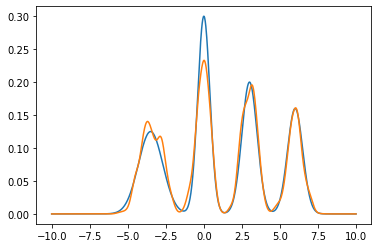

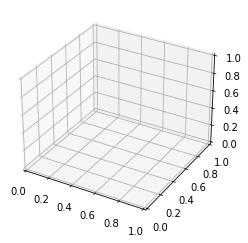

In [19]:
#Univariate Data
true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5]) ** 2
w_t = np.array([0.25, 0.25, 0.3, 0.2])
xgrid = np.linspace(-10, 10, 1000)

pert_mu, pert_sigma, pert_w = perturb_normal_mixture(true_mu, true_sigma, w_t)
plt.plot(xgrid, eval_univariate_mixture_dens(true_mu, true_sigma, w_t, xgrid))
plt.plot(xgrid, eval_univariate_mixture_dens(pert_mu, pert_sigma, pert_w , xgrid))

#Multivariate Data
true_mu_bi = np.array([  [-7,-7] , [0,0] , [1,4] , [0,7]  ])
true_sigma_bi = np.array([  [[10,1] , [1, 10]] ,   [[10 , 1] , [1 , 1]] ,[[10,1] , [2, 1]],[[1,0.5] , [0.5, 1]]   ])
grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 

#Few components otherwise computations are very long
#Also the grid of points is less refined
pert_mu_bi, pert_sigma_bi, pert_w_bi = perturb_normal_mixture(true_mu_bi, true_sigma_bi, w_t,comp_out = 100)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Original Mixture');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Perturbed Mixture');

#Attention
#I generate the grid_2D with a for loop, and it is vector of coordinates,so grid_2D=[[x_1,y_1], ... [x_n,y_n]]
#To plot in 3D however i need to construct a grid using np.meshgrid and evaluate the densities over this grid,
#which is constructed differently from grid_2D.
#However, .prob(..) only works on grid_2D, so i reshape the output of eval_multivariate_mixture_dens 
# to have the same shape of the np.meshgrid, and it seems to reorder the points correctly, but it is lucky or wrong

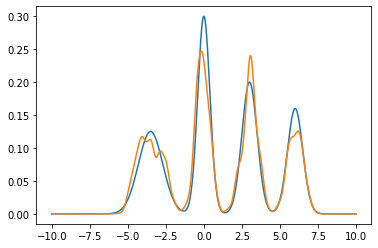

In [48]:
#Univariate Data
true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5]) ** 2
w_t = np.array([0.25, 0.25, 0.3, 0.2])
xgrid = np.linspace(-10, 10, 1000)

pert_mu, pert_sigma, pert_w = perturb_normal_mixture(true_mu, true_sigma, w_t, comp_out=1000)
plt.plot(xgrid, eval_univariate_mixture_dens(true_mu, true_sigma, w_t, xgrid))
plt.plot(xgrid, eval_univariate_mixture_dens(pert_mu, pert_sigma, pert_w , xgrid))


In [22]:
summed_pert_w = [ sum(pert_w[:x]) for x in range(0, len(pert_w))]
s = np.random.uniform(0,1,10000)
idx_to_sample=[bisect.bisect_left(summed_pert_w, sample)-1 for sample in s]
sampled_df = np.array([tfd.Normal(pert_mu[idx], pert_sigma[idx]).sample() for idx in idx_to_sample])

In [23]:
#idx_to_sample
sampled_df

array([-3.20678906e+00,  5.15506053e+00, -3.48798364e+00,  3.61717818e+00,
        3.56353426e-01,  2.50039674e+00, -2.55692879e-02, -4.12982514e+00,
        3.00253090e+00,  3.29141349e+00, -2.66708693e-01, -5.31915705e-01,
        2.66207959e-03,  1.32822772e-01, -3.15074630e+00,  5.45517603e-01,
       -3.33675906e+00, -3.42794683e+00,  5.94423855e+00,  4.12325962e+00,
       -4.89483041e-01, -2.89636056e-02,  3.05220847e+00,  5.33545634e+00,
        2.50705575e+00, -1.55144892e-01,  6.39634154e+00, -1.70905853e+00,
       -2.61206417e-01,  2.20219684e+00, -9.30992210e-02, -4.49701045e+00,
        3.00116258e+00,  8.83189913e-01, -3.44961368e+00,  5.05809023e+00,
        5.88274863e-01,  5.14287176e-01,  2.93195186e+00, -5.47622132e-02,
       -2.13350901e-01, -4.72123653e-01,  6.20793046e-01,  6.73690142e-01,
        5.55075580e+00, -4.31739821e+00, -3.35338658e-01,  3.13069731e+00,
        2.97616516e+00, -3.85619297e+00,  1.80306568e-01, -3.84186311e+00,
       -3.77452338e+00, -

<AxesSubplot:ylabel='Density'>

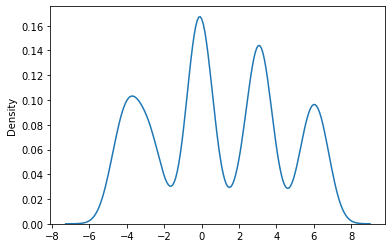

In [51]:
sns.kdeplot(data=sampled_df)

<AxesSubplot:ylabel='Count'>

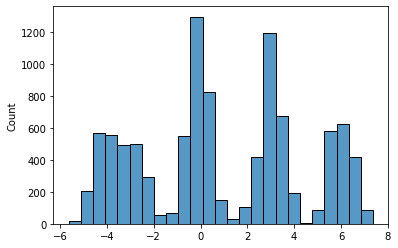

In [50]:
sns.histplot(data=sampled_df)

In [20]:
#Multivariate Data
true_mu_bi = np.array([  [-7,-7] , [0,0] , [1,4] , [0,7]  ])
true_sigma_bi = np.array([  [[10,1] , [1, 10]] ,   [[10 , 1] , [1 , 1]] ,[[10,1] , [2, 1]],[[1,0.5] , [0.5, 1]]   ])
grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 

#Few components otherwise computations are very long
#Also the grid of points is less refined
pert_mu_bi, pert_sigma_bi, pert_w_bi = perturb_normal_mixture(true_mu_bi, true_sigma_bi, w_t,comp_out = 1000)

In [23]:
summed_pert_w2D = [ sum(pert_w[:x]) for x in range(0, len(pert_w))]
s = np.random.uniform(0,1,1000)
idx_to_sample=[bisect.bisect_left(summed_pert_w, sample)-1 for sample in s]
sampled_df = np.array([tfd.MultivariateNormalFullCovariance(pert_mu_bi[idx], pert_sigma_bi[idx]).sample() for idx in idx_to_sample])


IndexError: index 6706 is out of bounds for axis 0 with size 1000

In [68]:
[elem [0] for elem in sampled_df]

[-1.977805468441877,
 -5.538504484647256,
 2.202499076738355,
 1.8840607140757042,
 0.36836625230094455,
 -0.4354098218829765,
 -2.8944766345669137,
 -2.5292651619136706,
 -3.832544382112821,
 -2.683118677107702,
 2.0464837366147677,
 0.13692891172305266,
 3.1795685934220135,
 -1.7958419391141869,
 -2.96162492549253,
 -7.732475990426505,
 -2.3635730941694146,
 -4.454991274260897,
 -6.557342385651953,
 -11.592092751481585,
 5.077430258739767,
 -8.617177825984086,
 0.843937165089427,
 -2.039052891595005,
 -2.821298531732759,
 -9.410651330831136,
 1.0167726851417203,
 -4.581070977050808,
 2.115981004290423,
 5.469244848172442,
 -6.540586976822078,
 1.1794778016099432,
 -0.9636223187825015,
 -0.20202859013657623,
 -3.518666248630486,
 -2.086427473594649,
 -10.671182478725257,
 0.5669022946612321,
 -0.9115232255698571,
 -0.44951510749673207,
 -0.31344750906447394,
 -1.8097972019534174,
 -8.617382720590522,
 -4.8087361961459685,
 -7.294942792360681,
 -0.8101871871730568,
 -3.5478816300040688

In [76]:
sampled_df

array([[ -0.87443564,  -1.03840545],
       [ -3.06708911,  -1.24410886],
       [ -7.24634925,  -4.44787481],
       ...,
       [ -0.48562295,  -5.38515937],
       [-10.96347402,  -4.97355361],
       [ -0.14102729,  -0.0930026 ]])

<AxesSubplot:>

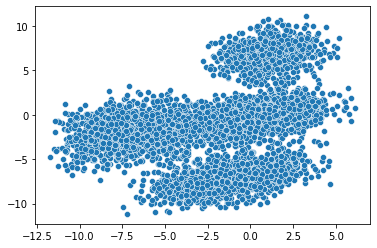

In [75]:
sns.scatterplot(x=[elem[0] for elem in sampled_df], y=[elem[1] for elem in sampled_df],)

In [6]:
true = np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t, grid_2D), newshape = X.shape)

In [7]:
perturbed = np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape)

In [74]:
np.save('sampled_2D.npy', sampled_df)